# Projeto 02 – Notebook 1 : Classificação Automática  
## Introdução

**Unidade Curricular:** Inteligência Artificial  
**Projeto:** Project 02 – Data Mining / Machine Learning  
**Notebook:** Classificação Automática

Este notebook apresenta o desenvolvimento realizado pelo **Grupo 3**, composto por **Tiago Sousa (20735), Rodrigo Castro (23143), Rogério Gomes (27216), Paulo Costa (29851)** e **Laís Carvalho (51067)**, no âmbito do trabalho prático da disciplina de Inteligência Artificial.

O objetivo é construir modelos de **classificação automática** capazes de prever resultados de desempenho de pilotos numa corrida de Fórmula 1, com base em informação conhecida **antes da corrida** (por exemplo: posição de partida, ano, equipa, etc.).

Serão estudadas duas variáveis alvo distintas:

- **`scored_points`** – indica se o piloto **marcou pontos** na corrida (1) ou não (0);
- **`podium_finish`** – indica se o piloto **terminou no pódio**, ou seja, nas três primeiras posições (1) ou não (0).

### Contexto e objetivo

No contexto da Fórmula 1, equipas e analistas procuram antecipar não apenas a probabilidade de um piloto marcar pontos, mas também a probabilidade de alcançar um **resultado de elite**, como o pódio, uma vez que estas previsões influenciam:

- estratégias de corrida (paragens na box, escolha de pneus, ritmo de prova);
- decisões de equipa (ordens de equipa, gestão de risco);
- análise de performance de pilotos e construtores ao longo das épocas;
- comunicação e conteúdos analíticos para media e fãs.

Assim, a tarefa de classificação pode ser formulada de duas formas complementares:

> **Dado um conjunto de características de uma corrida e de um piloto, prever se ele irá marcar pontos (1) ou não (0).**

> **Dado o mesmo conjunto de características, prever se o piloto irá terminar no pódio (1) ou não (0).**

A variável `scored_points` permite modelar um nível geral de sucesso competitivo, enquanto a variável `podium_finish` representa um evento mais raro e exigente, associado aos melhores desempenhos em cada corrida, introduzindo um cenário de maior desbalanceamento das classes.

Para este estudo será utilizado o dataset **Formula 1 World Championship (1950–2020)**, disponibilizado no **Kaggle**, o mesmo conjunto de dados utilizado nos restantes notebooks do Projeto 02, garantindo consistência na análise ao longo de todo o trabalho.


In [1]:
# 1. Importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn-v0_8')  # se der erro, trocar para 'seaborn'


## 2. Dados utilizados

Vamos utilizar os seguintes ficheiros do dataset de Fórmula 1:

- `results.csv` – resultados detalhados de cada piloto em cada corrida;
- `races.csv` – informação sobre cada corrida (ano, ronda, circuito, etc.);
- `drivers.csv` – informação básica dos pilotos;
- `constructors.csv` – informação das equipas (construtores).

### 2.1 Carregamento dos ficheiros


In [2]:
# Ajustar o caminho conforme a pasta onde os ficheiros foram extraídos (ex.: 'archive/results.csv')
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')

results.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### 2.2 Visão geral e critérios de seleção de dados

Nem todas as colunas disponíveis são necessárias para a tarefa de classificação.  
Para este problema vamos focar-nos em variáveis que podem ser conhecidas **antes da corrida**:

- Ano da corrida (`year` – tabela `races`);
- Ronda do campeonato (`round` – tabela `races`);
- Posição de partida na grelha (`grid` – tabela `results`);
- Piloto (`driverId` – tabela `drivers`);
- Equipa / construtor (`constructorId` – tabela `constructors`).

A variável alvo (**target**) será:

- `scored_points` – variável binária igual a 1 se o piloto marcou pontos (> 0) e 0 caso contrário.

Como os regulamentos de atribuição de pontos mudaram ao longo da história, poderemos restringir a análise a anos mais recentes (por exemplo, a partir de 2000) para obter um cenário mais homogéneo.


Adicionalmente, para efeitos de exploração e análise comparativa, será considerada uma segunda variável alvo:

- `podium_finish` – variável binária igual a 1 se o piloto terminou a corrida numa das três primeiras posições (pódio) e 0 caso contrário.

Esta variável permite modelar a probabilidade de um piloto alcançar um resultado de elite, sendo um critério de desempenho estável ao longo da história da Fórmula 1 e independente das alterações nos sistemas de atribuição de pontos.


In [3]:
# 2.3 Preparação inicial: juntar resultados com corridas, pilotos e construtores

# Converter 'position' para numérico (pode ser útil mais tarde)
results['position'] = pd.to_numeric(results['position'], errors='coerce')

# Criar variável alvo binária: 1 se o piloto marcou pontos, 0 caso contrário
results['scored_points'] = (results['points'] > 0).astype(int)

# Juntar com races para obter ano e ronda
df = results.merge(races[['raceId', 'year', 'round']], on='raceId', how='left')

# Juntar com drivers (apenas algumas colunas)
df = df.merge(drivers[['driverId', 'code', 'nationality']], on='driverId', how='left')

# Juntar com constructors (equipa)
df = df.merge(constructors[['constructorId', 'name', 'nationality']].rename(
    columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'}
), on='constructorId', how='left')

df.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapTime,fastestLapSpeed,statusId,scored_points,year,round,code,nationality,constructor_name,constructor_nationality
0,1,18,1,1,22,1,1.0,1,1,10.0,...,1:27.452,218.300,1,1,2008,1,HAM,British,McLaren,British
1,2,18,2,2,3,5,2.0,2,2,8.0,...,1:27.739,217.586,1,1,2008,1,HEI,German,BMW Sauber,German
2,3,18,3,3,7,7,3.0,3,3,6.0,...,1:28.090,216.719,1,1,2008,1,ROS,German,Williams,British
3,4,18,4,4,5,11,4.0,4,4,5.0,...,1:28.603,215.464,1,1,2008,1,ALO,Spanish,Renault,French
4,5,18,5,1,23,3,5.0,5,5,4.0,...,1:27.418,218.385,1,1,2008,1,KOV,Finnish,McLaren,British


In [4]:
# Variável alvo alternativa: terminou no pódio (Top 3)
df['podium_finish'] = (
    pd.to_numeric(df['position'], errors='coerce') <= 3
).astype(int)

# Tabela resumo da distribuição das variáveis alvo
target_dist = pd.DataFrame({
    "scored_points": df["scored_points"].value_counts(normalize=True),
    "podium_finish": df["podium_finish"].value_counts(normalize=True)
}).fillna(0).rename_axis("classe").rename(columns={"scored_points":"scored_points (proporção)",
                                                   "podium_finish":"podium_finish (proporção)"})
target_dist


,scored_points (proporção),podium_finish (proporção)
classe,,
0,0.694682,0.873089
1,0.305318,0.126911


## 3. Preparação e limpeza dos dados

### 3.1 Seleção temporal e remoção de linhas inválidas

Para reduzir a heterogeneidade histórica do campeonato (mudanças de regras de pontos, número de carros, etc.), vamos restringir a análise a corridas a partir do ano **2000**.

Também serão removidas linhas com valores em falta em variáveis essenciais, como `grid` (posição na grelha).


In [5]:
# Filtrar apenas corridas a partir de 2000
df_model = df[df['year'] >= 2000].copy()

# Remover linhas com grid desconhecido (NaN)
df_model = df_model.dropna(subset=['grid'])

df_model.shape


(10079, 26)

### 3.2 Seleção de atributos (features) e variável alvo

Atributos numéricos escolhidos:

- `year`
- `round`
- `grid`

Atributos categóricos escolhidos:

- `code` (código do piloto, quando disponível)
- `constructor_name`
- `constructor_nationality`

Variável alvo (duas opções para estudo):

- `scored_points` (0 = não marcou pontos, 1 = marcou pontos)
- `podium_finish` (0 = não terminou no pódio, 1 = terminou no pódio)

No código, a variável `TARGET` permite escolher qual das duas será usada para treinar e avaliar os modelos.

Seguidamente, vamos construir os conjuntos de treino e teste.


In [6]:
# Escolher a variável alvo para treino e avaliação
# Opções: 'scored_points' ou 'podium_finish'
TARGET = 'podium_finish'  # alterar para 'podium_finish' para o segundo estudo


In [7]:
# Definir features e target
feature_cols_num = ['year', 'round', 'grid']
feature_cols_cat = ['code', 'constructor_name', 'constructor_nationality']

X = df_model[feature_cols_num + feature_cols_cat]
y = df_model[TARGET]

# Separar treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((7055, 6), (3024, 6))

## 4. Pré-processamento e definição de modelos

Para tratar variáveis numéricas e categóricas de forma adequada, vamos utilizar um **ColumnTransformer** com:

- **StandardScaler** para atributos numéricos;
- **OneHotEncoder** para atributos categóricos.

Em seguida, vamos testar **três algoritmos de classificação**:

1. **Logistic Regression**
2. **Random Forest**
3. **K-Nearest Neighbors (KNN)**

e comparar o seu desempenho com base em métricas como **accuracy**, **precision**, **recall** e **F1-score**.


In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4.1 Pré-processamento

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols_num),
        ('cat', categorical_transformer, feature_cols_cat)
    ]
)


### 4.2 Avaliação inicial de vários algoritmos

Vamos construir um pipeline para cada algoritmo e comparar o desempenho em validação cruzada e no conjunto de teste.


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definição dos modelos
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

results_summary = []

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', clf)])
    
    # Validação cruzada (accuracy)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    
    # Ajustar no treino e avaliar no teste
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results_summary.append({
        'model': name,
        'cv_accuracy_mean': cv_scores.mean(),
        'test_accuracy': acc,
        'test_precision': prec,
        'test_recall': rec,
        'test_f1': f1
    })

results_df = pd.DataFrame(results_summary)
results_df


,model,cv_accuracy_mean,test_accuracy,test_precision,test_recall,test_f1
0,LogisticRegression,0.898937,0.895503,0.674772,0.515081,0.584211
1,RandomForest,0.892275,0.893188,0.655172,0.529002,0.585366
2,KNN,0.890999,0.883598,0.603675,0.533643,0.566502


## 5. Otimização de hiperparâmetros do modelo selecionado

Com base nos resultados anteriores, iremos selecionar o modelo com melhor desempenho (por exemplo, **Random Forest**) e proceder a uma otimização simples dos seus hiperparâmetros usando **GridSearchCV**.


In [10]:
from sklearn.model_selection import GridSearchCV

# Assumindo que o RandomForest foi o melhor (ajustar se necessário após ver a tabela)
best_base_model_name = 'RandomForest'
best_base_model = models[best_base_model_name]

pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', best_base_model)])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    pipe_rf, param_grid, cv=3,
    scoring='f1', n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor F1 (validação cruzada):", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Melhor F1 (validação cruzada): 0.6107304238893506


### 5.1 Avaliação final do melhor modelo

Vamos avaliar o modelo otimizado no conjunto de teste, analisando:

- matriz de confusão;
- métricas de classificação (accuracy, precision, recall, F1);
- curva ROC e AUC.


In [11]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

best_model = grid_search.best_estimator_

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_proba_test)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC-ROC:   {auc:.3f}")


Accuracy:  0.894
Precision: 0.658
Recall:    0.527
F1-score:  0.585
AUC-ROC:   0.926


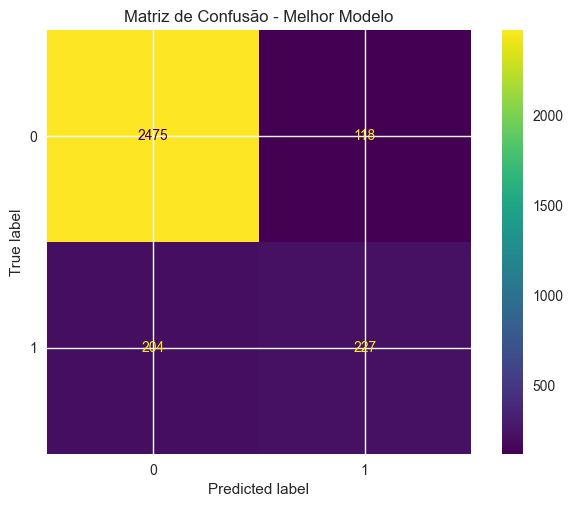

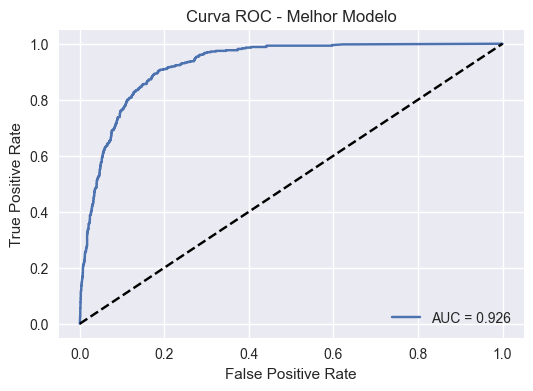

In [12]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - Melhor Modelo')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Melhor Modelo')
plt.legend()
plt.show()


## 6. Conclusões 

Este projeto permitiu modelar dois níveis distintos de sucesso na Fórmula 1, utilizando variáveis conhecidas antes da corrida (como grelha de partida e construtor) para prever resultados competitivos.

### 6.1. Análise Comparativa: Pontos vs. Pódio

Sucesso Geral (scored_points): Esta variável serviu para prever a competitividade básica. Com uma incidência de cerca de 30,5% nos dados, os modelos tendem a ser mais estáveis nesta categoria, sendo útil para equipas do "meio da tabela" que procuram consistência.

Elite de Performance (podium_finish): Prever o pódio revelou-se um desafio maior devido ao desbalanceamento das classes (apenas 12,6% de ocorrência). Contudo, o modelo Random Forest obteve uma AUC-ROC de 0,926, demonstrando uma capacidade excecional de separar os candidatos reais ao pódio dos restantes pilotos.

### 6.2 Desempenho e Variáveis Chave

Modelo Final: O Random Forest foi o algoritmo mais equilibrado, apresentando o melhor compromisso entre precisão e sensibilidade após a otimização de hiperparâmetros.

Fatores Determinantes: A posição na grelha (grid) e a equipa (constructor) consolidaram-se como os preditores mais fortes para ambos os alvos, confirmando que o desempenho técnico e a qualificação de sábado são os principais pilares do resultado de domingo.

### 6.3 Valor Prático e Limitações

Os modelos construídos oferecem uma ferramenta analítica valiosa para antecipar o risco e o benefício de estratégias de corrida. Enquanto a previsão de pontos ajuda na gestão de expectativas para o campeonato, a previsão de pódio permite focar em momentos de alta visibilidade e retorno mediático.

Como limitações, o estudo não considera fatores dinâmicos como a meteorologia ou falhas mecânicas súbitas, sugerindo que a inclusão de dados de treinos livres poderia refinar ainda mais a precisão das previsões para futuras iterações.
